#Partie Machine learning de projet statistique 9FM, modélisation des montants des sinistres

Après avoir examiner le sujet en question statistiquement par les modéles de statistique à savoir GLM et ainsi que l'analyse de type de distribusiton de la variable CoutMoyen qu'on cherche à expliquer, on passe à ce stade à la partie de la prédiction de cette variable à partir des modéles de machine learning à savoir :



1.   Regression linaire
2.   L'arbre de classification et de regression CART
3.   Random forest
4.   Gradient boost tree
5.   XGBoost regressor
6.   LightGBM
7.   Catboost
8.   KNN regressor
9.   SVRegression
10.  ADABoost via LightGBM 

Nous avons de même esquisser un plan pour cette présentation de résultas, que dans chaque modele on fit notre data suivant les parametres par défauts et on examine le modele au testset et apres on oprimise les parametres via l'hyperparametres tuning par la méthode de grid search et puis on cherche à comparer les résultas avec et sans tuning the parametres et en suite en visualise l'importance de chaque variable dans la prédiction de la variable CoutMoyen via la méthode de SHAP directement on plot les plots de shap pour comprendre mieux l'architecture de l'apprentissage de chaque modéle.



1.   Fit without tuning the parametres
2.   Fit with tuning the parametres
3.   Compare the RMSE in each case
4.   Feature  importance
5.   Shap plots




A la fin on va comparer les erreurs pour chaque modéle et le qualifiant de cette étude sera celui avec le moins des erreurs avec un trade-off entre le trainset et le testset, et cette analyse a été gagnée par le modele **LightGBM**, où on commence par l'exploration de la data qui contient les clients avec les sinitres qui occupe un pourtentage de **5%** dans la data totale ce qui montre le caractère de unbalanced data en question, c'est pourquoi qu'on décide d'élaborer le sujet avec la data sans ceux avec 0 en charge totale (i.e 0 en CoutMoyen) vu que les résultats de l'étude sont sensibles par le bruit en terme d'apprentissage que génére l'utilisation de cette partie de non-charge-totale, donc on continue par ce mode et on verra bien ce que cela donne comme résultat.









In [ ]:
1+1

2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


A la fin de ce notebook, on aura l'idée sur combien du temps le code exige pour être executer

In [ ]:
import time
start_time = time.time()

#Download les libraires

Pour la suite de cette étude on aura besoin de plusieurs libraries, donc pour faciliter la tâche on les importer toutes ensemble d'un coup dans la partie suivante :

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import preprocessing
!pip install ppscore
import ppscore as pps
from sklearn.impute import KNNImputer
from fancyimpute import KNN
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow import keras
from keras.layers import Dropout
from keras import regularizers
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Dans la suite de l'analyse en partie de modeling, on aura besoin de d'un moyen pour mieux visualiser l'importance des variables explicatives pour mener à bien expliquer la variable CoutMoyen, le moyen en question est **SHAP**

**SHAP** (SHapley Additive exPlanations) est une approche théorique des jeux pour expliquer la sortie de tout modèle d'apprentissage automatique.

  Il relie l'allocation de crédit optimale avec des explications locales en utilisant les valeurs classiques de **Shapley issues de la théorie des jeux** et leurs extensions associées, et c'est ce que nous allons utiliser dans la partie de data modeling pour mieux comprendre certains résultats obtenus à cet égard .

In [ ]:
pip install shap

In [ ]:
#from catboost import *
import shap
shap.initjs()

la variable 'Data' est la base de donnée sur quoi nous allons se baser pour faire toute notre étude de machine learning et arriver au stade de prédire les CoutMoyen d'un nouveau client à notre agence d'assurance. 

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Projet statistique/Data/Data_accid.csv")
data 

,Unnamed: 0,Nombre_accident,Charge_total,exposition,Combustion,puissance_fiscale,SEXE,ageClient,Ancienneté de permis,Ancienneté du contrat,Ancienneté du vehicule,CoutMoyen,TrancheAge,TrancheAgeVehicule,TrancheAgeContrat,TrancheAgePermis,NewCost,Cluster
0,0,1,4550.00,0.008219,E,6,F,70.913929,48.445243,4.913929,6.875599,4550.00,F,A,B,E,16.570558,2
1,1,2,4055.90,1.000000,G,6,M,59.617385,38.020363,4.905715,2.439767,2027.95,E,A,B,D,12.657631,2
2,2,1,2830.00,1.000000,G,9,M,58.203457,31.311431,3.900240,6.625599,2830.00,E,A,B,D,14.144757,2
3,3,1,11717.87,1.000000,E,6,F,46.913929,18.611910,2.819644,1.747262,11717.87,D,A,A,B,22.713439,2
4,4,1,3639.25,1.000000,E,8,F,61.913929,31.983573,5.663929,1.314168,3639.25,E,A,B,D,15.381687,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,3135,1,456.00,0.265027,G,7,M,40.945243,14.075120,5.647502,7.773101,456.00,C,A,B,B,7.697002,2
3136,3136,1,632.58,1.000000,G,8,M,48.545003,26.228097,2.913929,3.486311,632.58,D,A,A,C,8.584305,2
3137,3137,1,6504.00,0.994521,G,10,M,45.275838,15.803217,1.572382,19.192505,6504.00,D,C,A,B,18.666383,7
3138,3138,1,6000.00,0.476712,E,11,F,46.913929,26.572382,1.434292,14.225359,6000.00,D,B,A,C,18.171206,2


In [ ]:
data.drop(columns=['Unnamed: 0'], inplace=True)

se débarasser de nouveau ID généré par défaut suite au code précédent, donc on se retrouve avec les colonnes suivantes :

In [ ]:
data

,Nombre_accident,Charge_total,exposition,Combustion,puissance_fiscale,SEXE,ageClient,Ancienneté de permis,Ancienneté du contrat,Ancienneté du vehicule,CoutMoyen,TrancheAge,TrancheAgeVehicule,TrancheAgeContrat,TrancheAgePermis,NewCost,Cluster
0,1,4550.00,0.008219,E,6,F,70.913929,48.445243,4.913929,6.875599,4550.00,F,A,B,E,16.570558,2
1,2,4055.90,1.000000,G,6,M,59.617385,38.020363,4.905715,2.439767,2027.95,E,A,B,D,12.657631,2
2,1,2830.00,1.000000,G,9,M,58.203457,31.311431,3.900240,6.625599,2830.00,E,A,B,D,14.144757,2
3,1,11717.87,1.000000,E,6,F,46.913929,18.611910,2.819644,1.747262,11717.87,D,A,A,B,22.713439,2
4,1,3639.25,1.000000,E,8,F,61.913929,31.983573,5.663929,1.314168,3639.25,E,A,B,D,15.381687,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,1,456.00,0.265027,G,7,M,40.945243,14.075120,5.647502,7.773101,456.00,C,A,B,B,7.697002,2
3136,1,632.58,1.000000,G,8,M,48.545003,26.228097,2.913929,3.486311,632.58,D,A,A,C,8.584305,2
3137,1,6504.00,0.994521,G,10,M,45.275838,15.803217,1.572382,19.192505,6504.00,D,C,A,B,18.666383,7
3138,1,6000.00,0.476712,E,11,F,46.913929,26.572382,1.434292,14.225359,6000.00,D,B,A,C,18.171206,2


Un check typique des données de la data en question pour mieux s'assurer que nous n'avons pas besoin de faire de la data cleaning, ce qui est confirmé par le résultat du code suivant :

In [ ]:
liste_colonne_data = list(data.columns)
for i in liste_colonne_data :
  print(data[i].value_counts(dropna=False))
  print('\n')

1    2942
2     177
3      18
4       3
Name: Nombre_accident, dtype: int64


6000.00     879
4500.00      69
12000.00     52
6804.00      37
3000.00      35
           ... 
2221.40       1
2445.60       1
10139.57      1
1988.35       1
5021.43       1
Name: Charge_total, Length: 1654, dtype: int64


1.000000    1618
0.000000     104
0.997260      50
0.994521      24
0.991781      19
            ... 
0.032787       1
0.416438       1
0.098361       1
0.502732       1
0.811475       1
Name: exposition, Length: 498, dtype: int64


G    2298
E     842
Name: Combustion, dtype: int64


8     794
6     770
7     769
9     273
10    233
11    116
12     83
5      77
13     12
14     11
3       1
4       1
Name: puissance_fiscale, dtype: int64


M    2479
F     661
Name: SEXE, dtype: int64


50.913929    41
49.913929    41
53.913929    35
58.913929    32
56.913929    31
             ..
58.142026     1
41.665127     1
45.676078     1
39.189767     1
27.684292     1
Name: ageClient, Length: 201

toute les colonnes sont cleans, donc c'est gagné à ce stade, mais l'important c'est qu'on n'aura pas besoin de toutes ces colonnes pour la suite de l'étude, alors, on se débarassera de certains d'elles, ce qui est remarquable par le résultat suivant, et c'est parti ! 

In [ ]:
data.columns

Index(['Nombre_accident', 'Charge_total', 'exposition', 'Combustion',
       'puissance_fiscale', 'SEXE', 'ageClient', 'Ancienneté de permis',
       'Ancienneté du contrat', 'Ancienneté du vehicule', 'CoutMoyen',
       'TrancheAge', 'TrancheAgeVehicule', 'TrancheAgeContrat',
       'TrancheAgePermis', 'NewCost', 'Cluster'],
      dtype='object')

In [ ]:
data.drop(columns =['TrancheAge', 'TrancheAgeVehicule', 'TrancheAgeContrat',
       'TrancheAgePermis', 'NewCost', 'Cluster' ,'Charge_total' ,'Nombre_accident'] , inplace = True)

In [ ]:
data

,exposition,Combustion,puissance_fiscale,SEXE,ageClient,Ancienneté de permis,Ancienneté du contrat,Ancienneté du vehicule,CoutMoyen
0,0.008219,E,6,F,70.913929,48.445243,4.913929,6.875599,4550.00
1,1.000000,G,6,M,59.617385,38.020363,4.905715,2.439767,2027.95
2,1.000000,G,9,M,58.203457,31.311431,3.900240,6.625599,2830.00
3,1.000000,E,6,F,46.913929,18.611910,2.819644,1.747262,11717.87
4,1.000000,E,8,F,61.913929,31.983573,5.663929,1.314168,3639.25
...,...,...,...,...,...,...,...,...,...
3135,0.265027,G,7,M,40.945243,14.075120,5.647502,7.773101,456.00
3136,1.000000,G,8,M,48.545003,26.228097,2.913929,3.486311,632.58
3137,0.994521,G,10,M,45.275838,15.803217,1.572382,19.192505,6504.00
3138,0.476712,E,11,F,46.913929,26.572382,1.434292,14.225359,6000.00


par la suite, on va faire le run des certains modeles qui exigeent l'élaboration des données numériques, et alors, un preprocessing est demandé d'être fait sur les colonnes **Combustion** et **SEXE**

In [ ]:
data = pd.get_dummies(data = data, columns = ['Combustion' , 'SEXE'])

In [ ]:
data

,exposition,puissance_fiscale,ageClient,Ancienneté de permis,Ancienneté du contrat,Ancienneté du vehicule,CoutMoyen,Combustion_E,Combustion_G,SEXE_F,SEXE_M
0,0.008219,6,70.913929,48.445243,4.913929,6.875599,4550.00,1,0,1,0
1,1.000000,6,59.617385,38.020363,4.905715,2.439767,2027.95,0,1,0,1
2,1.000000,9,58.203457,31.311431,3.900240,6.625599,2830.00,0,1,0,1
3,1.000000,6,46.913929,18.611910,2.819644,1.747262,11717.87,1,0,1,0
4,1.000000,8,61.913929,31.983573,5.663929,1.314168,3639.25,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3135,0.265027,7,40.945243,14.075120,5.647502,7.773101,456.00,0,1,0,1
3136,1.000000,8,48.545003,26.228097,2.913929,3.486311,632.58,0,1,0,1
3137,0.994521,10,45.275838,15.803217,1.572382,19.192505,6504.00,0,1,0,1
3138,0.476712,11,46.913929,26.572382,1.434292,14.225359,6000.00,1,0,1,0


on cherche à voir la distribution de la varible à expliquer CoutMoyen, et dans on aperçoit que la valeur 6000 est en excés, ce qui qualifié notre data par une unbalanced dataset ce qui remarquable par le pick dans le plot suivant

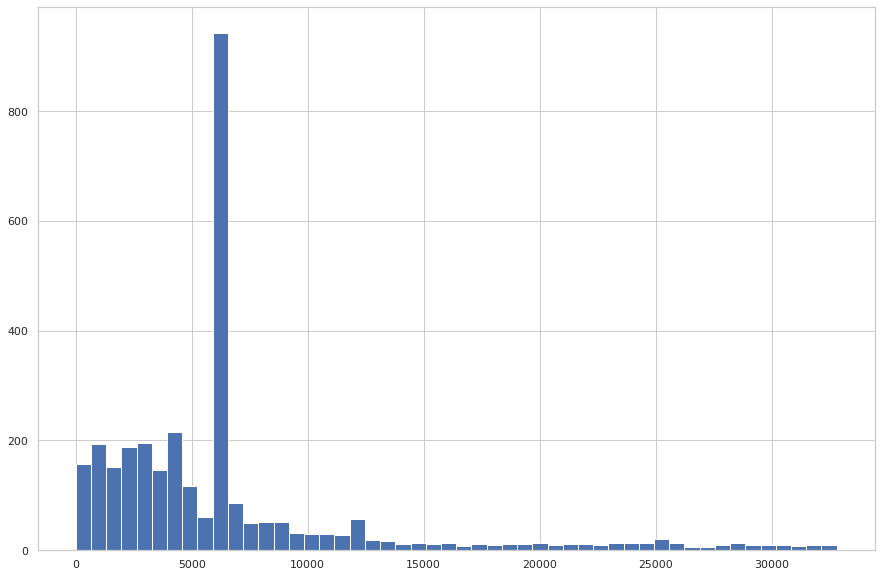

In [ ]:
data.CoutMoyen.hist(bins=50 , figsize=(15,10))

#Stratified sampling 

Le concept de stratified est beaucoup plus important au moment ou on cherche à faire un split de notre data en train et en test, ce qui valorisable à ce stade est le fait que le test dataset mieux qu'elle soit une data représentative au train data set mieux que le résultat des models implementés pour la prédiction soient intéressants, ce qui est va être élaborer dans cette partie

In [ ]:
data["CoutMoyen_cat"] = pd.cut(data["CoutMoyen"], bins=[0., 2500, 5000, 7500, 12500, 15000, np.inf], labels=[1, 2, 3, 4, 5 , 6])

la variable cat_moyen est construit au but de prendre la même distrubition, dans le train et le test suivant la variable CoutMoyen (à partir de quoi le coutmoyen_cat s'est fait)

In [ ]:
data

,exposition,puissance_fiscale,ageClient,Ancienneté de permis,Ancienneté du contrat,Ancienneté du vehicule,CoutMoyen,Combustion_E,Combustion_G,SEXE_F,SEXE_M,CoutMoyen_cat
0,0.008219,6,70.913929,48.445243,4.913929,6.875599,4550.00,1,0,1,0,2
1,1.000000,6,59.617385,38.020363,4.905715,2.439767,2027.95,0,1,0,1,1
2,1.000000,9,58.203457,31.311431,3.900240,6.625599,2830.00,0,1,0,1,2
3,1.000000,6,46.913929,18.611910,2.819644,1.747262,11717.87,1,0,1,0,4
4,1.000000,8,61.913929,31.983573,5.663929,1.314168,3639.25,1,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3135,0.265027,7,40.945243,14.075120,5.647502,7.773101,456.00,0,1,0,1,1
3136,1.000000,8,48.545003,26.228097,2.913929,3.486311,632.58,0,1,0,1,1
3137,0.994521,10,45.275838,15.803217,1.572382,19.192505,6504.00,0,1,0,1,3
3138,0.476712,11,46.913929,26.572382,1.434292,14.225359,6000.00,1,0,1,0,3


les codes suivants dans cette partie font l'affaire

#Strat_train_set + strat_test_set

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data.drop(columns='CoutMoyen'), data["CoutMoyen_cat"]):
 strat_train_set = data.loc[train_index]
 strat_test_set = data.loc[test_index]

In [ ]:
strat_train_set.reset_index(inplace=True)
strat_test_set.reset_index(inplace=True)

In [ ]:
strat_train_set.drop(columns=['index'],inplace=True)
strat_test_set.drop(columns=['index'],inplace=True)

In [ ]:
strat_train_set.drop(columns =['CoutMoyen_cat'] , inplace=True)
strat_test_set.drop(columns =['CoutMoyen_cat'] , inplace=True)

In [ ]:
data.drop(columns =['CoutMoyen_cat'] , inplace=True)

notre dans a le shape suivant, ce qui ce montre par 

**20%** en test dataset
**80%** en train dataset 

In [ ]:
strat_test_set.shape

(628, 11)

In [ ]:
strat_train_set.shape

(2512, 11)

#split X and y 

In [ ]:
X = data.drop(columns=['CoutMoyen'])
y = data.CoutMoyen

In [ ]:
y_train = strat_train_set['CoutMoyen']
y_test = strat_test_set['CoutMoyen']

In [ ]:
X_train = strat_train_set.copy()
X_train.drop(columns = ['CoutMoyen'] , inplace = True)

In [ ]:
X_test = strat_test_set.copy()
X_test.drop(columns = ['CoutMoyen'] , inplace = True)

test set une une data représentative à celle de train set ce qui est représenté par les résultats suivants, on trouve qu'on a les mêmes distribustion pour toutes les variables 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f258c7556d0>,
      dtype=object)

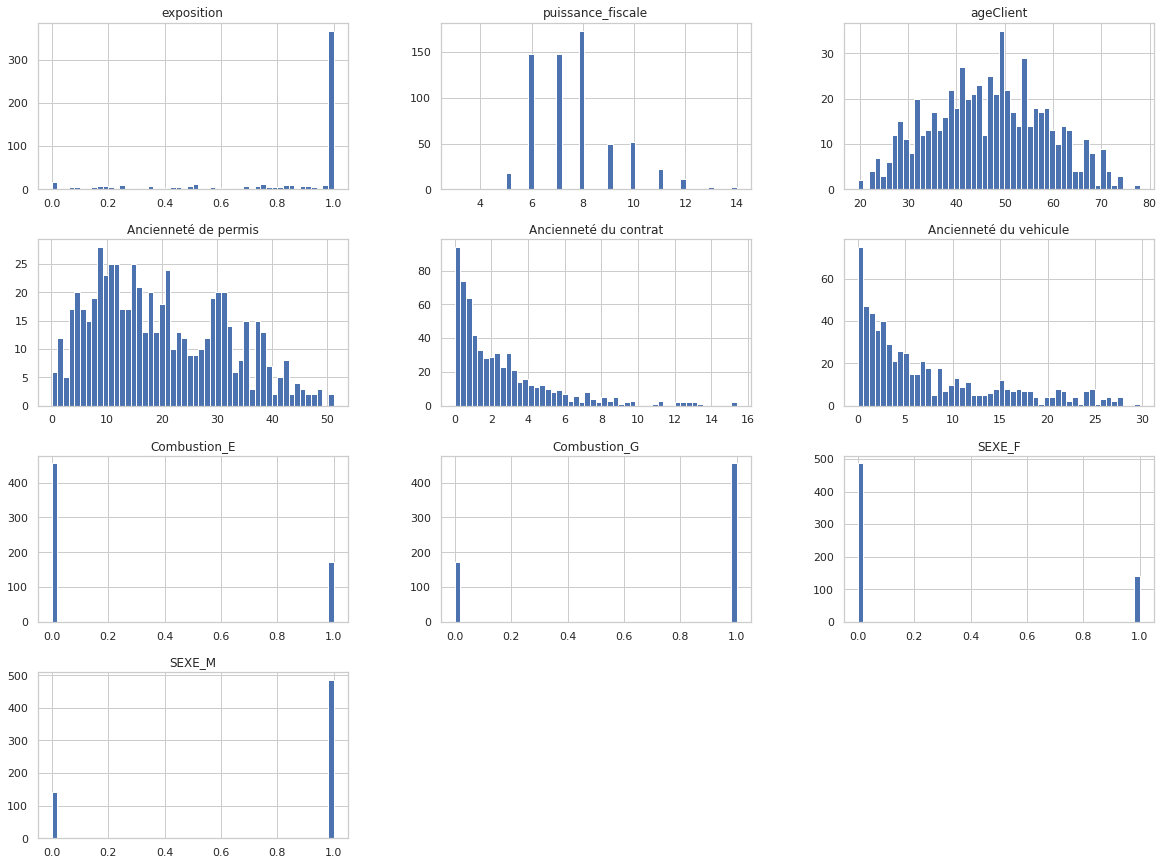

In [ ]:
X_test.hist(bins=50 , figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25966696d0>,
      dtype=object)

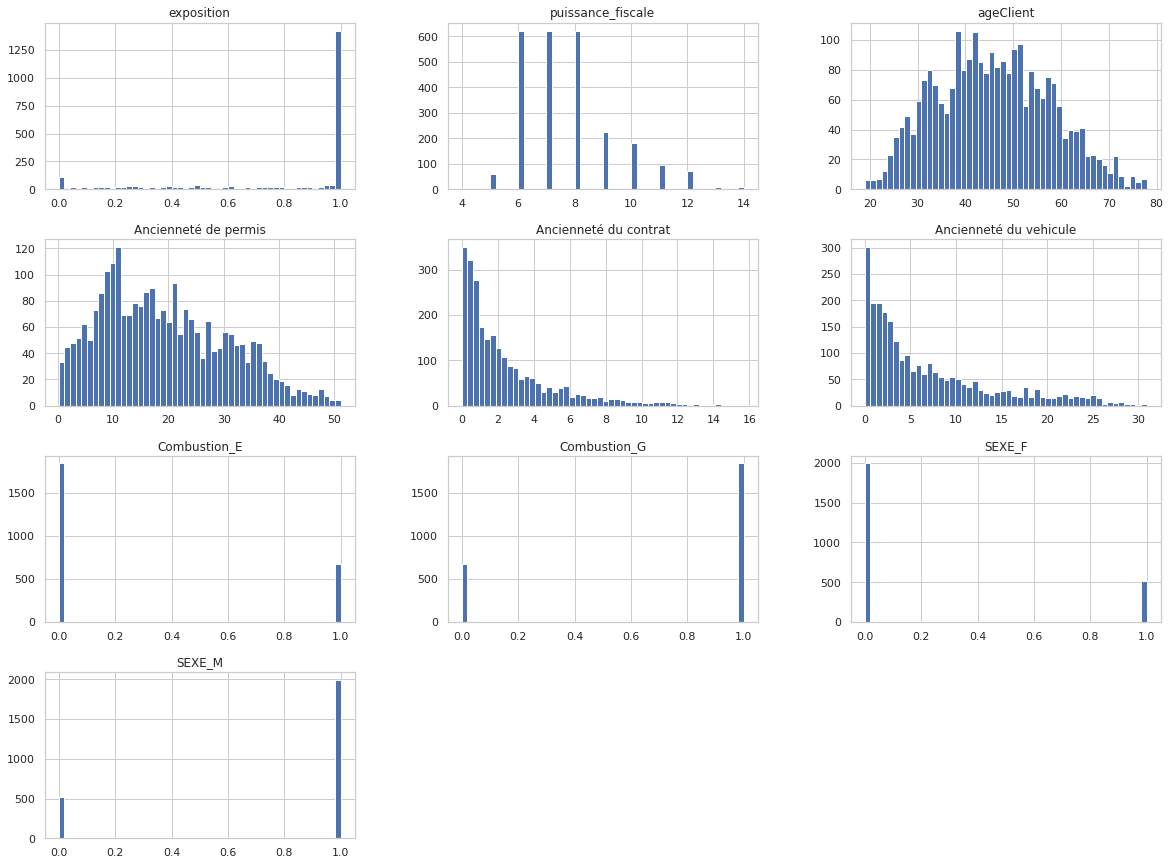

In [ ]:
X_train.hist(bins=50 , figsize=(20,15))

#Data Modeling

ces deux fonctions sont utilisés pour le hyperparametres tuning suivant la méthode de gridsearch 

In [ ]:
# fonction d'optimisation d'hyperparamètres
def optimized_hyp_model(model,params_range):
  grid = GridSearchCV(estimator=model
                      ,param_grid=params_range
                      ,cv=10
                      ,n_jobs=-1)
  grid.fit(X, y)
  opt_ = {'best_hyerparameters':grid.best_params_,
          'best_CV_score':grid.best_score_,
          'best_model':grid.best_estimator_}
  return opt_

# fonction d'optimisation d'hyperparamètres + prédiction à partir du meilleur modèle.
def optimized_hyp_model_prediction(model,params_range,x_data,y_data):
  grid = GridSearchCV(estimator=model
                      ,param_grid=params_range
                      ,cv=10
                      ,n_jobs=-1)
  grid.fit(x_data, y_data)
  opt_ = {'best_hyerparameters':grid.best_params_,
          'best_CV_score':grid.best_score_,
          'best_model':grid.best_estimator_}
  best_model = grid.best_estimator_
  best_model.fit(x_data,y_data)  
  return [opt_ , best_model.predict(strat_train_set)]

In [ ]:
print( time.time() - start_time, 's' )

14.535430431365967 s


# Linear regression

On commence dans cette partie de data modeling par le modéle de la regression linaire, cette régression linéaire est l'un des algorithmes de machine learning qui consiste à trouver la meilleure fonction permettant de définir une variable de sortie (l'élément à prédire pour nous c'est **CoutMoyen**) à partir d'une des variables explicatives en entrée (les prédicteurs en ce cas les autres variable en colonnes avec le CoutMoyen en data)  

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)
print(linear_reg.coef_)

[-1059.87202416  -101.76270739     9.78169838   -12.2950282
   -49.16452159    92.54143513   -75.38100714    75.38100714
  -219.25673028   219.25673028]


Apres avoir faire le fit de modéle pour le train data set, on examinera le modele par l'utilisation de la fonction de measure de performance à savoir dans ce cas, RMSE, qui calcul la racine de la moyenne carrée des écarts des erreurs entre l'observative et le prédictive. 

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=linear_reg.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=linear_reg.predict(X_test))))

Sur X_train : RMSE =  6244.765239066315
Sur X_test : RMSE =  6359.964237348881


La partie suivante est consacrée pour visualiser l'importance de chaque variable dans la prédiction de la variable CoutMoyen :

Feature: 0, Score: -1059.87202
Feature: 1, Score: -101.76271
Feature: 2, Score: 9.78170
Feature: 3, Score: -12.29503
Feature: 4, Score: -49.16452
Feature: 5, Score: 92.54144
Feature: 6, Score: -75.38101
Feature: 7, Score: 75.38101
Feature: 8, Score: -219.25673
Feature: 9, Score: 219.25673


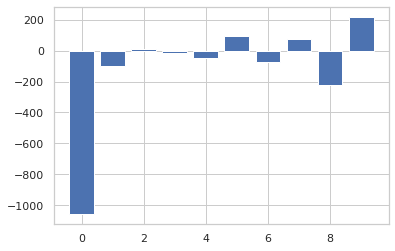

In [ ]:
from matplotlib import pyplot
importance = linear_reg.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
liste_cc = list(importance)
for i in range(len(liste_cc)):
  print(i+1 ,' : ', liste_cc[i],' = ', X_train.columns[i])

1  :  -1059.8720241554697  =  exposition
2  :  -101.76270739333475  =  puissance_fiscale
3  :  9.781698376418134  =  ageClient
4  :  -12.295028198162424  =  Ancienneté de permis
5  :  -49.16452159096118  =  Ancienneté du contrat
6  :  92.54143513270539  =  Ancienneté du vehicule
7  :  -75.38100714271751  =  Combustion_E
8  :  75.38100714271737  =  Combustion_G
9  :  -219.25673027556402  =  SEXE_F
10  :  219.25673027556408  =  SEXE_M


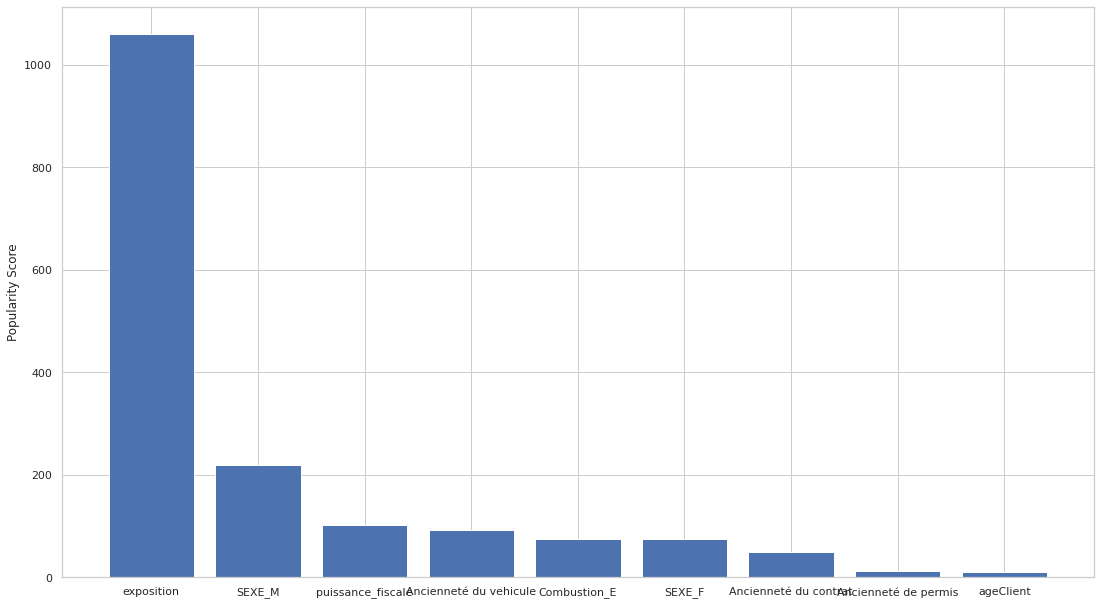

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
liste_features_importance_regression_linear = [
     ('exposition', abs(liste_cc[0])),
     (u'puissance_fiscale', abs(liste_cc[1])),
     (u'ageClient', abs(liste_cc[2])),
     (u'Ancienneté de permis',abs(liste_cc[3])),
     (u'Ancienneté du contrat', abs(liste_cc[4])),
     (u'Ancienneté du vehicule', abs(liste_cc[5])),
     (u'Combustion_E', abs(liste_cc[6])),
     (u'SEXE_F', abs(liste_cc[7])),
     (u'SEXE_M', abs(liste_cc[8]))]

# sort in-place from highest to lowest
liste_features_importance_regression_linear.sort(key=lambda x: x[1], reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
features = list(zip(*liste_features_importance_regression_linear))[0]
score = list(zip(*liste_features_importance_regression_linear))[1]
features_pos = np.arange(len(features)) 
  
plt.bar(features_pos, score,align='center')
plt.xticks(features_pos, features) 
plt.ylabel('Popularity Score')
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

On peut aussi élaborer de plus sur cette partie de la regression linear en faisant la régularization du modele pour tirer le plus possible de ce modéle, mais en passant à des modéle pour intéressant et plus explicative est beaucoup mieux et utile que stagner à cet égard, donc on passe au modéle suivant, le modele CART

In [ ]:
print(time.time() - start_time, 's')

15.15514326095581 s


#Classification and regressor tree

  **L’apprentissage par arbre de décision** désigne une méthode basée sur l'utilisation d'un arbre de décision comme modèle prédictif. 

  Dans ces structures d'arbre, les feuilles représentent les valeurs de la variable-cible et les embranchements correspondent à des combinaisons de variables d'entrée qui mènent à ces valeurs.
  
   Dasn cette analyse de décision, un arbre de décision peut être utilisé pour représenter de manière explicite les décisions réalisées et les processus qui les amènent. 

   **C'est une technique d'apprentissage supervisé** : on utilise un ensemble de données pour lesquelles on connaît la valeur de la variable-cible afin de construire l'arbre (données dites étiquetées), puis on extrapole les résultats à l'ensemble des données de test. Et c'est exactement le plan esquissé pour cette partie 

In [ ]:
# Imports
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image, display
import pydotplus

def jupyter_graphviz(m, **kwargs):
    dot_data = StringIO()
    export_graphviz(m, dot_data, **kwargs)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

In [ ]:
# build cart model
dtr = DecisionTreeRegressor()

In [ ]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=dtr.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=dtr.predict(X_test))))

Sur X_train : RMSE =  0.0
Sur X_test : RMSE =  9093.730302854205


Bamm ,mais c'est de overfitting avec le trainset using model's default arguments, on va essayer d'optimize les parametres de ce modéle pour eviter l'overfitiing et avoir un apprentissage approprié

In [ ]:
from sklearn import tree
import graphviz

l'arbre ci-dessous montre qui elle est tellement large qu'on craint de se retrouver dnas l'overfitting, donc on cherchera à optimizer ce learning par touché aux parametres du model en question

In [ ]:
dot_data = tree.export_graphviz(dtr, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

plot the tree

In [ ]:
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [ ]:
# Definition de  la grille d'hyperparamètres de 'params_dtr'
params_dtr = {
'max_depth': list(np.arange(3,8,1)),
'max_leaf_nodes': list(np.arange(40,50,1))
}

dtr_grid_tuned = optimized_hyp_model(DecisionTreeRegressor(),params_dtr)
dtr_grid_tuned

In [ ]:
# construction d'un modèle cart
dtr_best_model = dtr_grid_tuned['best_model']
print('best score : ',dtr_grid_tuned['best_CV_score'])

In [ ]:
# performance du best model sur le X_train
dtr_best_model.fit(X_train, y_train)
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=dtr_best_model.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=dtr_best_model.predict(X_test))))

On fait le plot de la nouvelle arbre avec une nouvelle architecture d'apprentissage 

In [ ]:
pip install dtreeviz

In [ ]:
dot_data_best = tree.export_graphviz(dtr_best_model, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
graphviz.Source(dot_data_best, format="png") 

In [ ]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(dtr_best_model, X_train, y_train,
                target_name="CoutMoyen",
                feature_names=X_train.columns)
viz

l'importance des variables pour expliquer et prédire le CoutMoyen

In [ ]:
dtr_best_model.feature_importances_

In [ ]:
plt.barh(X_train.columns, dtr_best_model.feature_importances_)

In [ ]:
sorted_idx_dtr = dtr_best_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx_dtr], dtr_best_model.feature_importances_[sorted_idx_dtr])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
!pip install dtreeviz

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(dtr_best_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(dtr_best_model).shap_values(X_train), X_train)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(dtr_best_model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(dtr_best_model).shap_values(X_test), X_test)

In [ ]:
print( time.time() - start_time, 's' )

#Random forest

**Les forêts d'arbres décisionnels** our **Random forest** font partie des techniques d'apprentissage automatique. 

  Cet algorithme combine les concepts de sous-espaces aléatoires et de bagging (bootstrap + aggregatting. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

Pour le premier pas dans ce modéle on essaie de donner la chance au modele par les parametres par défauts et après en fait de l'hyperparametre tuning pour mieux optimizer le modele

In [ ]:
# Instantiate model random forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=rf.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=rf.predict(X_test))))

On commence dans la partie Hyperparametres tunning par le méthode de grid search pour le random forest

In [ ]:
rf.get_params()

In [ ]:
# Define the grid of hyperparameters
params_rf = {
'max_depth': list(np.arange(5,8,1)),
'n_estimators': [550,570,600,650]
}


rf_grid_tuned = optimized_hyp_model(RandomForestRegressor(),params_rf)

rf_best_model = rf_grid_tuned['best_model']
print('best score : ',rf_grid_tuned['best_CV_score'])
rf_grid_tuned

In [ ]:
rf_best_model = rf_grid_tuned['best_model']
rf_best_model.fit(X_train,y_train)
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=rf_best_model.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=rf_best_model.predict(X_test))))

Sur X_train : RMSE =  5892.663324883142
Sur X_test : RMSE =  6291.795684883923


L'importance et l'impact de chaque variable dans la prédiction de CoutMoyen

In [ ]:
rf_best_model.feature_importances_

array([0.11459291, 0.05243223, 0.15925059, 0.1461781 , 0.1763821 ,
       0.32697008, 0.00539936, 0.00594419, 0.00614803, 0.00670242])

<BarContainer object of 10 artists>

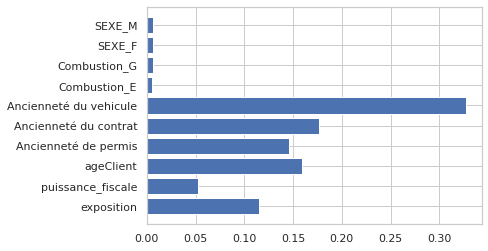

In [ ]:
plt.barh(X_train.columns, rf_best_model.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

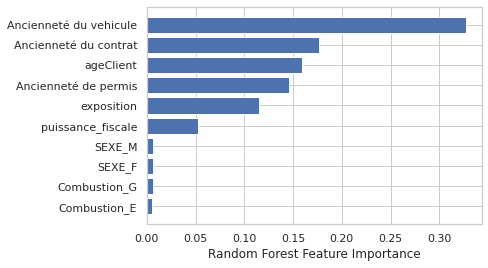

In [ ]:
sorted_idx_rf = rf_best_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx_rf], rf_best_model.feature_importances_[sorted_idx_rf])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(rf_best_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[100], X_train.iloc[100])

In [ ]:
shap.summary_plot(shap.TreeExplainer(rf_best_model).shap_values(X_train), X_train)

In [ ]:
X_train.columns

In [ ]:
shap.dependence_plot('Ancienneté du vehicule', shap.TreeExplainer(rf_best_model).shap_values(X_train), X_train)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(rf_best_model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(rf_best_model).shap_values(X_test), X_test)

In [ ]:
print( time.time() - start_time, 's' )

#Gradient boost tree

**Gradient boost tree** est une technique d'apprentissage automatique pour les problèmes de régression et de classification.

**Gradient Boost Tree** produit un modèle de prédiction sous la forme d'un ensemble de modèles de prédiction faibles, généralement des arbres de décision. 

Lorsqu'un arbre de décision est l'apprenant faible, l'algorithme qui en résulte est appelé arbres boostés par gradient ou gradient boost tree, qui surpassent généralement random forest. le modéle se construit par des étapes comme le font d'autres méthodes de **boosting**, et il les généralise en permettant l'optimisation d'une fonction de perte différentiable arbitraire.

In [ ]:
gbt = GradientBoostingRegressor(criterion='mse')
gbt.fit(X_train, y_train)

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=gbt.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=gbt.predict(X_test))))

Hyperparameters tuning par la méthode gridsearch pour GBT

In [ ]:
# hyperparameters tuning
params_gbt= {'max_depth':[3,4,5],
    'n_estimators':[50,100],
    }

tuned_gbt = optimized_hyp_model(GradientBoostingRegressor(criterion='mse'), params_gbt)
tuned_gbt

In [ ]:
# on teste les performances du best model sur X_train
#gbt_best_model = GradientBoostingRegressor(criterion='mse', max_depth=3, n_estimators=550)
gbt_best_model = tuned_gbt['best_model']
gbt_best_model.fit(X_train,y_train)
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=gbt_best_model.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=gbt_best_model.predict(X_test))))

In [ ]:
plt.barh(X_train.columns, gbt_best_model.feature_importances_)

In [ ]:
sorted_idx_gbt = gbt_best_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx_gbt], gbt_best_model.feature_importances_[sorted_idx_gbt])
plt.xlabel("Gradient boost tree Feature Importance")

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(gbt_best_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(gbt_best_model).shap_values(X_train), X_train)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(gbt_best_model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(gbt_best_model).shap_values(X_test), X_test)

In [ ]:
print( time.time() - start_time, 's' )

#XGBoost regressor

**XGBoost** signifie eXtreme Gradient Boosting. C'est une implémentation de machines de boosting de gradient d'une maniere plus développée; 

Why use XGBoost : 

1.   la vitesse de l'execution
2.   La haute performance du modele



In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', max_depth=4, n_estimators=450)
xgb.fit(X_train, y_train)

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=xgb.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=xgb.predict(X_test))))

Hyperparameters tuning par la méthode gridsearch pour Xgboost


In [ ]:
# hyperparameters tuning
params_xgb= {
    'n_estimators':[350,400,450,500],
    'max_depth':[3,4,5]
    }

tuned_xgb = optimized_hyp_model(XGBRegressor(objective='reg:squarederror'), params_xgb)

In [ ]:
tuned_xgb

In [ ]:
# on teste les performances du best model sur X_train
xgb_best_model = tuned_xgb['best_model']
xgb_best_model.fit(X_train,y_train)
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=xgb_best_model.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=xgb_best_model.predict(X_test))))

In [ ]:
xgb_bb = XGBRegressor(objective='reg:squarederror', max_depth=4, n_estimators=500)
xgb_bb.fit(X_train, y_train)
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=xgb_bb.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=xgb_bb.predict(X_test))))

In [ ]:
plt.barh(X_train.columns, xgb_best_model.feature_importances_)

In [ ]:
sorted_idx_xgb = xgb_best_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx_xgb], xgb_best_model.feature_importances_[sorted_idx_xgb])
plt.xlabel("XGBOOST Feature Importance")

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_best_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

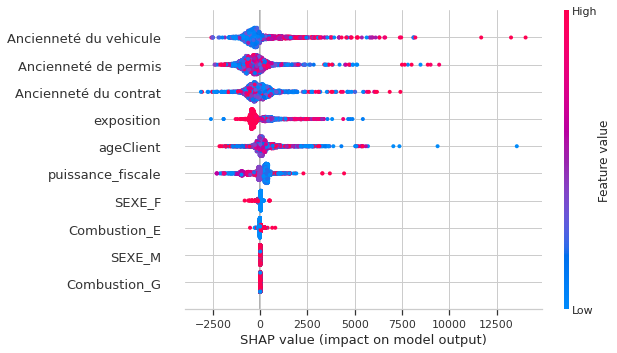

In [ ]:
shap.summary_plot(shap.TreeExplainer(xgb_best_model).shap_values(X_train), X_train)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_best_model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

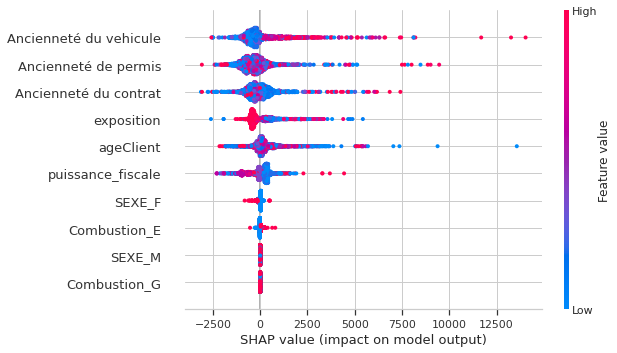

In [ ]:
shap.summary_plot(shap.TreeExplainer(xgb_best_model).shap_values(X_train), X_train)

In [ ]:
print( time.time() - start_time, 's' )

231.65079951286316 s


#LightGBM

**LightGBM** présente de nombreux avantages de **XGBoost**, notamment une optimisation clairsemée, un entraînement parallèle, des fonctions de perte multiples, la régularisation, l'ensachage et l'arrêt précoce.

Une différence majeure entre les deux réside dans la construction d'arbres. **LightGBM** ne développe pas une arborescence niveau par niveau - ligne par ligne - comme le font la plupart des autres implémentations.

 Au lieu de cela, il fait pousser des arbres au niveau des feuilles. Il choisit la feuille qui, selon lui, entraînera la plus forte diminution de la perte. En outre, **LightGBM** n'utilise pas l'algorithme d'apprentissage d'arbre de décision basé sur le tri largement utilisé, qui recherche le meilleur point de partage sur les valeurs de caractéristiques triées, comme le font **XGBoost** ou d'autres implémentations. 
 
 Au lieu de cela, LightGBM implémente un algorithme d'apprentissage d'arbre de décision basé sur un histogramme hautement optimisé, qui offre de grands avantages à la fois en termes d'efficacité et de consommation de mémoire.
 
  L'algorithme **LightGBM** utilise deux nouvelles techniques appelées **Gradient-Based** **One-Side Sampling** (GOSS) et Exclusive Feature Bundling (EFB) qui permettent à l'algorithme de s'exécuter plus rapidement tout en maintenant un haut niveau de précision.

In [ ]:
from lightgbm import LGBMRegressor
lgbmr = LGBMRegressor(n_estimators=570)
lgbmr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=570, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=lgbmr.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=lgbmr.predict(X_test))))

Sur X_train : RMSE =  1642.3574960875042
Sur X_test : RMSE =  6832.275545800053


Hyperparameters tuning par la méthode gridsearch pour LightGBM


In [ ]:
# hyperparameters tuning
params_lgbmr= {'n_estimators':[550,560,570,580]}
tuned_lgbmr = optimized_hyp_model(LGBMRegressor(random_state=42), params_lgbmr)

In [ ]:
tuned_lgbmr

In [ ]:
# on teste les performances du best model sur X_train
lgbmr_best_model = tuned_lgbmr['best_model']
lgbmr_best_model.fit(X_train,y_train)
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=lgbmr_best_model.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=lgbmr_best_model.predict(X_test))))

In [ ]:
plt.barh(X_train.columns, lgbmr_best_model.feature_importances_)

In [ ]:
sorted_idx_lgbmr = lgbmr_best_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx_lgbmr], lgbmr_best_model.feature_importances_[sorted_idx_lgbmr])
plt.xlabel("LightGBM Feature Importance")

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(lgbmr_best_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(lgbmr_best_model).shap_values(X_test), X_test)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(lgbmr_best_model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(lgbmr_best_model).shap_values(X_train), X_train)

In [ ]:
print( time.time() - start_time, 's' )

#Catboost

**Note : Le nom «CatBoost» vient de deux mots «Catégorie» et «Boosting».**

**CatBoost** est un algorithme d'apprentissage automatique à source ouverte récemment de Yandex. Il peut facilement s'intégrer à des frameworks d'apprentissage en profondeur tels que TensorFlow de Google et Core ML d'Apple. Il peut fonctionner avec divers types de données pour aider à résoudre un large éventail de problèmes auxquels les entreprises sont confrontées aujourd'hui. Pour compléter, il offre la meilleure précision de sa catégorie.

Il est particulièrement puissant de deux manières:

Il donne des résultats de pointe sans formation approfondie aux données généralement requise par d'autres méthodes d'apprentissage automatique, et
fournit un support puissant et prêt à l'emploi pour les formats de données plus descriptifs qui accompagnent de nombreux problèmes commerciaux.


Comme indiqué, la bibliothèque fonctionne bien avec plusieurs catégories de données, telles que l'audio, le texte, l'image, y compris les données historiques.

«**Boost**» provient de l'algorithme d'apprentissage automatique de renforcement de gradient, car cette bibliothèque est basée sur une bibliothèque de renforcement de gradient. L'amplification de gradient est un algorithme d'apprentissage automatique puissant qui est largement appliqué à plusieurs types de défis commerciaux tels que la détection de fraude, les éléments de recommandation, les prévisions et il fonctionne également bien. Il peut également renvoyer de très bons résultats avec relativement moins de données, contrairement aux modèles DeepLearning qui doivent apprendre à partir d'une quantité massive de données.

In [ ]:
from catboost import CatBoostRegressor
catb = CatBoostRegressor(iterations=10000)
catb.fit(X_train, y_train)

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=catb.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=catb.predict(X_test))))

Hyperparameters tuning par la méthode gridsearch pour Catboost


In [ ]:
catb.get_all_params()

In [ ]:
# hyperparameters tuning
params_catb= {'iterations': [500,550,600]
    }

tuned_catb = optimized_hyp_model(CatBoostRegressor(random_state=42), params_catb)

In [ ]:
tuned_catb
''' {'best_CV_score': 0.8146618601815883,
 'best_hyerparameters': {'max_depth': 6, 'n_estimators': 550},
 'best_model': <catboost.core.CatBoostRegressor at 0x7fc94d217e80>} '''

In [ ]:
catb_best_model = tuned_catb['best_model']
catb_best_model.fit(X_train,y_train)

In [ ]:
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=catb_best_model.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=catb_best_model.predict(X_test))))

In [ ]:
plt.barh(X_train.columns, catb_best_model.feature_importances_)

In [ ]:
sorted_idx_catb = catb_best_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx_catb], catb_best_model.feature_importances_[sorted_idx_catb])
plt.xlabel("Catboost Feature Importance")

In [ ]:
pip install shap

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(catb_best_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(catb_best_model).shap_values(X_test), X_test)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(catb_best_model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.summary_plot(shap.TreeExplainer(catb_best_model).shap_values(X_train), X_train)

In [ ]:
print( time.time() - start_time, 's' )

#K-nearest neighbors regressor

En intelligence artificielle, plus précisément en apprentissage automatique, la méthode des k plus proches voisins est une méthode d’apprentissage supervisé. En abrégé k-NN ou KNN, de l'anglais k-nearest neighbors.

Dans ce cadre, on dispose d’une base de données d'apprentissage constituée de N couples « entrée-sortie ». Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre en compte (de façon identique) les k échantillons d'apprentissage dont l’entrée est la plus proche de la nouvelle entrée x, selon une distance à définir. Puisque cet algorithme est basé sur la distance, la normalisation peut améliorer sa précision.

In [ ]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=knr.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=knr.predict(X_test))))

Hyperparameters tuning par la méthode gridsearch pour K-nearest neighbors regressor


In [ ]:
knr.get_params()

In [ ]:
# Define the grid of hyperparameters 'params_knr'
params_knr = {
'n_neighbors': list(np.arange(1,50,1))
}

grid_knr = optimized_hyp_model(KNeighborsRegressor(), params_knr)

# Extract best model from 'grid_knr'
knr_best_model = grid_knr['best_model']

grid_knr

In [ ]:
# on teste les performances du best model sur X_train
knr_best_model.fit(X_train,y_train)
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=knr_best_model.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=knr_best_model.predict(X_test))))

#Support vector regressor

Les machines vectorielles de support (SVM) sont couramment et largement utilisées pour les problèmes de classification dans l'apprentissage automatique. 

In [ ]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X_train, y_train)

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=svr.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=svr.predict(X_test))))

In [ ]:
svr.get_params()

In [ ]:
# Define the grid of hyperparameters 'params_svr'
params_svr = {
    'kernel': ['rbf'], 
    'gamma': [0.01, 0.1, 0.2, 0.5],
    'C': [1, 10, 100]
    }

grid_svr = optimized_hyp_model(svm.SVR(epsilon = 0.01), params_svr)
grid_svr

In [ ]:
# Extract best model from 'grid_svr'
svr_best_model = grid_svr['best_model']
svr_best_model.fit(X_train,y_train)

In [ ]:
# on teste les performances du best model sur X_train
svr_best_model.fit(X_train,y_train)
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=svr_best_model.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=svr_best_model.predict(X_test))))

#Adaboost

**AdaBoost** (ou adaptive boosting) est, en intelligence artificielle et en apprentissage automatique, un méta-algorithme de boosting développé par Yoav Freund et Robert Schapire1. Il peut être utilisé en association avec de nombreux autres types d'algorithmes d'apprentissage afin d'améliorer les performances. Les sorties des autres algorithmes (classés classifieurs faibles) sont combinées en une somme pondérée qui représente la sortie finale du classeur boosté. AdaBoost est adaptatif dans le sens où les classeurs faibles subséquents sont ajustés en faveur des échantillons mal classés par les classeurs antérieurs.

**AdaBoost** est notablement sensible aux données bruitées ou peu corrélées. Cependant, dans certains problèmes, il peut s'avérer moins enclin au surapprentissage que d'autres algorithmes. Les sous-classeurs utilisés peuvent être faibles tant qu'ils proposent une performance au moins un peu supérieure à celle d'un classeur aléatoire, qui peut être prouvé que le modèle final converge vers un classeur fort.

Tous les algorithmes d'apprentissage tendent à correspondre plus à certains types de problèmes qu'à d'autres, et ont typiquement de nombreux paramètres et configurations différents qu'il est nécessaire d'ajuster pour atteindre une performance optimale sur un ensemble d'apprentissage fourni. AdaBoost (avec des arbres de décision comme classeurs faibles) est souvent désigné comme le meilleur classeur clé-en-main.

In [ ]:
adareg = AdaBoostRegressor(lgbmr_best_model, random_state=42, loss='square', n_estimators=50)
adareg.fit(X_train, y_train)

In [ ]:
# calcul du RMSE
print("Sur X_train : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=adareg.predict(X_train))))
print("Sur X_test : RMSE = ",math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=adareg.predict(X_test))))

In [ ]:
plt.barh(X_train.columns, adareg.feature_importances_)

In [ ]:
sorted_idx_ada = adareg.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx_ada], adareg.feature_importances_[sorted_idx_ada])
plt.xlabel("Cart Feature Importance")

In [ ]:
print( time.time() - start_time, 's' )

#Comparaison feature importance by model

In [ ]:
plot1 = plt.figure(1)
plt.barh(X_train.columns[sorted_idx_dtr], dtr_best_model.feature_importances_[sorted_idx_dtr])
plt.xlabel("Cart Feature Importance")
plot1.show()

plot2 = plt.figure(2)
plt.barh(X_train.columns[sorted_idx_rf], rf_best_model.feature_importances_[sorted_idx_rf])
plt.xlabel("Random Forest Feature Importance")
plot2.show()

plot3 = plt.figure(3)
plt.barh(X_train.columns[sorted_idx_gbt], gbt_best_model.feature_importances_[sorted_idx_gbt])
plt.xlabel("Gradient boost tree Feature Importance")
plot3.show()

plot4 = plt.figure(4)
plt.barh(X_train.columns[sorted_idx_xgb], xgb_best_model.feature_importances_[sorted_idx_xgb])
plt.xlabel("XGBOOST Feature Importance")
plot4.show()

plot5 = plt.figure(5)
plt.barh(X_train.columns[sorted_idx_xgb], lgbmr_best_model.feature_importances_[sorted_idx_xgb])
plt.xlabel("LightGBM Feature Importance")
plot5.show()

plot6 = plt.figure(6)
plt.barh(X_train.columns[sorted_idx_catb], catb_best_model.feature_importances_[sorted_idx_catb])
plt.xlabel("Catboost Feature Importance")
plot6.show()


In [ ]:
print( time.time() - start_time, 's' )

719.0528061389923 s


# Compare RMSE by model

In [ ]:
ada_rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=adareg.predict(X_test)))
cart_rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=dtr_best_model.predict(X_test)))
rf_rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=rf_best_model.predict(X_test)))
gbt_rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=gbt_best_model.predict(X_test)))
light_rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=lgbmr_best_model.predict(X_test)))
cat_rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=catb_best_model.predict(X_test)))
svr_rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=svr_best_model.predict(X_test)))
knr_rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=knr_best_model.predict(X_test)))

In [ ]:
pipe = {'svr_test =    ':  svr_rmse ,'knr_test =    ':  knr_rmse ,'ada_test =    ':  ada_rmse ,  'cart_test =   ':  cart_rmse ,  'rf_test =     ':  rf_rmse  , 'gbt_test =    ':  gbt_rmse  ,  'light_test =  ':  light_rmse  ,  'cat_test =    ':  cat_rmse}
{k: v for k, v in sorted(pipe.items(), key=lambda item: item[1])}

In [ ]:
ada_rmse_train = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=adareg.predict(X_train)))
cart_rmse_train = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=dtr_best_model.predict(X_train)))
rf_rmse_train = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=rf_best_model.predict(X_train)))
gbt_rmse_train = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=gbt_best_model.predict(X_train)))
light_rmse_train = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=lgbmr_best_model.predict(X_train)))
cat_rmse_train = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=catb_best_model.predict(X_train)))
svr_rmse_train = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=svr_best_model.predict(X_train)))
knr_rmse_train = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=knr_best_model.predict(X_train)))

In [ ]:
pipe_train = {'svr_train =    ':  svr_rmse_train ,'knr_train =    ':  knr_rmse_train ,'ada_train =    ':  ada_rmse_train ,  'cart_train =   ':  cart_rmse_train ,  'rf_train =     ':  rf_rmse_train  , 'gbt_train =    ':  gbt_rmse_train  ,  'light_train =  ':  light_rmse_train  ,  'cat_train =    ':  cat_rmse_train}
{k: v for k, v in sorted(pipe_train.items(), key=lambda item: item[1])}

#Ensemble learning

In [ ]:
from sklearn.ensemble import VotingRegressor
voting_clf = VotingRegressor(
 estimators=[('lr', linear_reg), 
             ('cart', dtr_best_model), 
             ('rf', rf_best_model),
             ('gbt', gbt_best_model), 
             ('xgb', xgb_best_model), 
             ('lightgbm', lgbmr_best_model),
             ('catboost', catb_best_model),
             ('svr', svr_best_model),
             ('knr', knr_best_model),
             ('adaboost', adareg)])

In [ ]:
name_train = []
for clf in (linear_reg, dtr_best_model, rf_best_model,gbt_best_model,xgb_best_model,lgbmr_best_model,svr_best_model,knr_best_model,adareg,voting_clf):
     clf.fit(X_train, y_train)
     y_pred = clf.predict(X_test)
     rmse = math.sqrt(metrics.mean_squared_error(y_true=y_train, y_pred=clf.predict(X_train)))
     name_train += [rmse]     

In [ ]:
name_train

In [ ]:
name = []
for clf in (linear_reg, dtr_best_model, rf_best_model,gbt_best_model,xgb_best_model,lgbmr_best_model,svr_best_model,knr_best_model,adareg,voting_clf):
     clf.fit(X_train, y_train)
     y_pred = clf.predict(X_test)
     rmse = math.sqrt(metrics.mean_squared_error(y_true=y_test, y_pred=clf.predict(X_test)))
     name += [rmse]

In [ ]:
name

#Extracting the nootebook as pdf

In [ ]:
def colab_pdf(file_name, notebookpath="/content/drive/My Drive/Colab Notebooks/"):
    import os

    # Checking if file_name passed is a sring.
    if not isinstance(file_name, str):
        raise TypeError(
            f"expected a string as file_name, but got {type(file_name)} instead."
        )

    # Using the defaults used by google.colab
    drive_mount_point = "/content/drive/"
    gdrive_home = os.path.join(drive_mount_point, "My Drive/")

    # If the drive is not already mounted, attempt to mount it.
    if not os.path.isdir(gdrive_home):
        from google.colab import drive

        drive.mount(drive_mount_point)

    # Check if the notebook exists in the Drive.
    if not os.path.isfile(os.path.join(notebookpath, file_name)):
        raise ValueError(f"file '{file_name}' not found in path '{notebookpath}'.")

    # Installing all the recommended packages.
    get_ipython().system(
        "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
    )

    # If pdf with the same name exists, remove it.
    pdf_file = os.path.join(gdrive_home, file_name.split(".")[0] + ".pdf")
    
    if os.path.isfile(pdf_file):
        os.remove(pdf_file)

    # Attempt to convert to pdf and save it in Gdrive home dir using jupyter nbconvert command.
    try:
        get_ipython().system(
            "jupyter nbconvert --output-dir='$gdrive_home' '$notebookpath''$file_name' --to pdf"
        )
    except:
        return "nbconvert error"

    # Attempt to download the file to system.
    try:
        from google.colab import files

        file_name = file_name.split(".")[0] + ".pdf"
        files.download(gdrive_home + file_name)
    except:
        return "File Download Unsuccessful. Saved in Google Drive"

    return "File ready to be Downloaded and Saved to Drive"

In [ ]:
from colab_pdf import colab_pdf
colab_pdf('deadline_25_avril.ipynb')

#The total time code excution

In [ ]:
heure,minute=0,0
 
def decoupe(seconde):
    heure = seconde /3600
    seconde %= 3600
    minute = seconde/60
    seconde%=60
    return (heure,minute,seconde)

In [ ]:
heure,minute=0,0
 
def decoupe(seconde):
    heure = seconde /3600
    seconde %= 3600
    minute = seconde/60
    seconde%=60
    return (heure,minute,seconde)